In [2]:
import jax.numpy as jnp
import bayes3d as b
import os
import jax
import functools
from jax.scipy.special import logsumexp
from functools import partial
from tqdm import tqdm
import matplotlib.pyplot as plt
# import bayes3d.genjax
# import genjax
import pathlib
import numpy as np

GenJAX not installed. Importing bayes3d without genjax dependencies.


In [3]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/


In [4]:
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=200.0, fy=200.0,
    cx=50.0, cy=50.0,
    near=0.0001, far=2.0
)


b.setup_renderer(intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)
# b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/10.0)
b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/1000000000.0)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


In [5]:
IDX = 13
table_pose = b.t3d.inverse_pose(
    b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 0.8, .15]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )
)

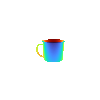

In [6]:
img = b.RENDERER.render(table_pose[None,...], jnp.array([13]))
b.get_depth_image(img[...,2]).convert("RGB")

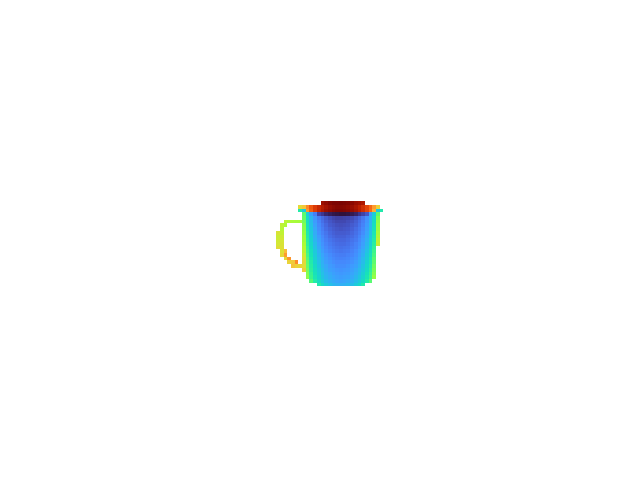

(37, 48)


In [7]:
%matplotlib widget
fig, axes = plt.subplots()
b.add_depth_image(axes,img[...,2])
location = None
def onclick(event):
    global location
    x, y = int(np.round(event.xdata)), int(np.round(event.ydata))
    location = (x,y)
    print(location)
    axes.axis("on")
    axes.scatter(x,y, c='r', s=10)

fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()

In [8]:
coordinate = img[location[1],location[0],:3]
b.clear()
b.show_cloud("data", img[:,:,:3].reshape(-1,3))
b.show_cloud("point", coordinate.reshape(-1,3), color=b.RED)
coordinate_in_object_frame = b.apply_transform(coordinate.reshape(-1,3), b.t3d.inverse_pose(table_pose))[0]
b.show_cloud("obj", b.RENDERER.meshes[IDX].vertices *5.0)
b.show_cloud("point2", coordinate_in_object_frame.reshape(-1,3) * 5.0, color=b.RED)

In [133]:
random_poses = jax.vmap(b.distributions.gaussian_vmf_jit, in_axes=(0,None, None, None))(jax.random.split(jax.random.PRNGKey(10),2000), table_pose, 0.05, 1.0)
coordinates = jnp.einsum("j,kij->ki", b.add_homogenous_ones(coordinate_in_object_frame), random_poses)
pixel_coordinates = jnp.round(b.camera.project_cloud_to_pixels(coordinates, intrinsics)).astype(jnp.int32)

images = b.RENDERER.render_many(random_poses[:,None,...], jnp.array([13]))
rendered_points = images[jnp.arange(images.shape[0]), pixel_coordinates[:,1], pixel_coordinates[:,0], :3]
distances = jnp.linalg.norm(rendered_points- coordinates[:,:3],axis=-1)
valid_indices = distances < 0.01
images_subset = images[valid_indices]
pixel_coordinates_subset = pixel_coordinates[valid_indices]


filter_size = 6
get_patch = lambda image, coordinate: jax.lax.dynamic_slice(image,
    (coordinate[1]-filter_size, coordinate[0]-filter_size, 0),
    (2*filter_size+1,2*filter_size+1,3))

patches = jax.vmap(get_patch)(images_subset, pixel_coordinates_subset)
patches_centered = patches - patches[:,filter_size,filter_size,:][...,None,None,:]

valid_indices = jnp.abs(patches_centered[:,:,2]).sum(-1).sum(-1) > 1e-4
images_subset = images_subset[valid_indices]
pixel_coordinates_subset = pixel_coordinates_subset[valid_indices]
patches_centered = patches_centered[valid_indices]

[48 40]


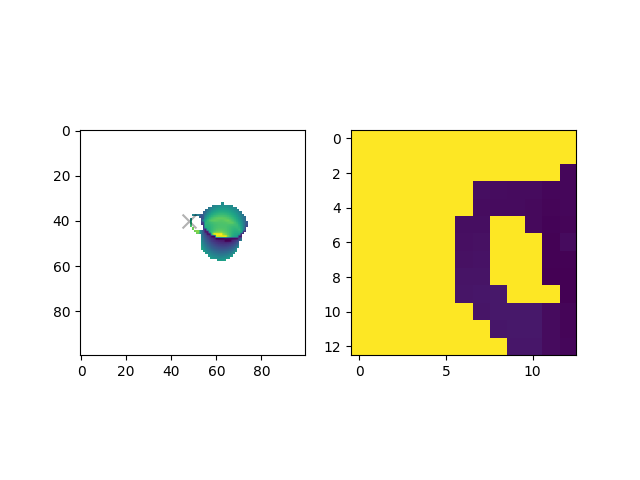

In [135]:
fig = plt.figure()
i = 21
ax = fig.add_subplot(1,2,1)
ax.imshow(b.preprocess_for_viz(images_subset[i,...,2]))
print(pixel_coordinates_subset[i,:])
ax.scatter(pixel_coordinates_subset[i,0], pixel_coordinates_subset[i,1], c='black', alpha=0.3,s=100, marker='x')
ax = fig.add_subplot(1,2,2)
ax.imshow(patches_centered[i, ..., 2])

In [88]:
# np.savez("training_data.npz", images_subset, pixel_coordinates_subset)
# data = np.load("training_data.npz")
# images_loaded = data["arr_0"]
# pixel_coordinates_loaded = data["arr_1"]
# print(images_loaded.shape, pixel_coordinates_loaded.shape)

# fig = plt.figure()
# N = 25
# for i in range(N):
#     ax = fig.add_subplot(5,5,i+1)
#     b.add_depth_image(ax, images_subset[i,...,2])
#     # ax.axis("on")
#     ax.scatter(pixel_coordinates_subset[i,0], pixel_coordinates_subset[i,1], c='black', alpha=0.3,s=10, marker='x')
# # plt.subplots_adjust(top = 0.0, bottom=0.0, hspace=0.1, wspace=0.4)
# plt.subplots_adjust(wspace=0, hspace=0)

In [110]:
@functools.partial(
    jnp.vectorize,
    signature='(m)->()',
    excluded=(1,2,),
)
def compute_error(ij, observed_xyz_padded, patch):
    slice = jax.lax.dynamic_slice(observed_xyz_padded, (ij[0], ij[1], 0), (2*filter_size + 1, 2*filter_size + 1, 3))
    slice_centered = slice - slice[filter_size, filter_size,:]
    distance = jnp.linalg.norm(
        patch - 
        slice_centered,
        axis=-1
    ).sum()
    return distance

def get_errors(observed_xyz, template):
    observed_xyz_padded = jax.lax.pad(observed_xyz,  -100.0, ((filter_size,filter_size,0,),(filter_size,filter_size,0,),(0,0,0,)))
    jj, ii = jnp.meshgrid(jnp.arange(observed_xyz.shape[1]), jnp.arange(observed_xyz.shape[0]))
    indices = jnp.stack([ii,jj],axis=-1)
    heatmap = compute_error(indices, observed_xyz_padded, template)
    return heatmap

get_errors_jit = jax.jit(get_errors)
get_errors_vmap_jit = jax.jit(jax.vmap(get_errors, in_axes=(None, 0)))

In [136]:
test_poses = jax.vmap(b.distributions.gaussian_vmf_jit, in_axes=(0,None, None, None))(jax.random.split(jax.random.PRNGKey(1000),200), table_pose,  0.05, 1.0)
test_images = b.RENDERER.render_many(test_poses[:,None,...], jnp.array([13]))

coordinates = jnp.einsum("j,kij->ki", b.add_homogenous_ones(coordinate_in_object_frame), test_poses)
pixel_coordinates = jnp.round(b.camera.project_cloud_to_pixels(coordinates, intrinsics)).astype(jnp.int32)

In [137]:
i = 1
b.clear()
b.show_cloud("1",test_images[i,...,:3].reshape(-1,3))
b.show_cloud("2",coordinates[i,...,:3].reshape(-1,3),color=b.RED)

(13, 13, 3)
(1044, 13, 13, 3)
(1044, 13, 13, 3)
134.21136


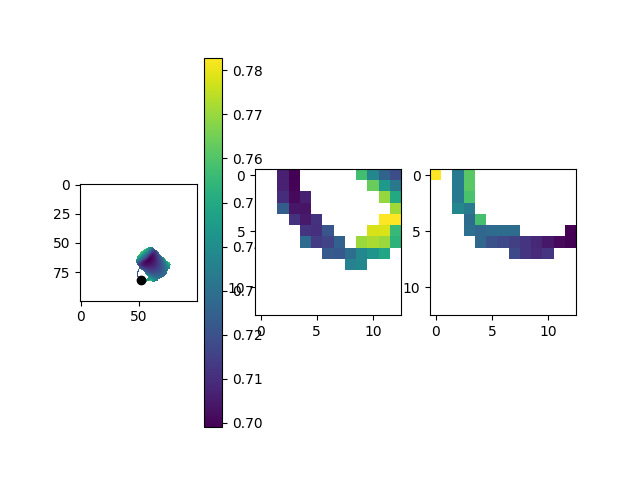

In [154]:
observed_xyz = test_images[i,...,:3]
x,y = pixel_coordinates[i]

observed_patch = get_patch(
    test_images[i,...,:3],
    pixel_coordinates[i]
)
observed_patch_centered = observed_patch - observed_patch[filter_size, filter_size,:]

print(observed_patch.shape)
print(patches_centered.shape)

fig = plt.figure()
ax = fig.add_subplot(1, 3, 1)
d = ax.imshow(b.preprocess_for_viz( observed_xyz[...,2]))
fig.colorbar(d)
ax.scatter(x,y,color="black")

ax = fig.add_subplot(1, 3, 2)
d = ax.imshow(b.preprocess_for_viz( observed_patch_centered[...,2]))


errors = patches_centered - observed_patch
print(errors.shape)
errors = jnp.linalg.norm(errors,axis=-1).sum(-1).sum(-1)

best_idx = errors.argmin()
print(errors[best_idx])
ax = fig.add_subplot(1, 3, 3)
d = ax.imshow(b.preprocess_for_viz( patches_centered[best_idx,...,2]))

(Array(297, dtype=int32), Array(58, dtype=int32), Array(54, dtype=int32))
2.1885343
50 41


Text(0.5, 1.0, 'hello')

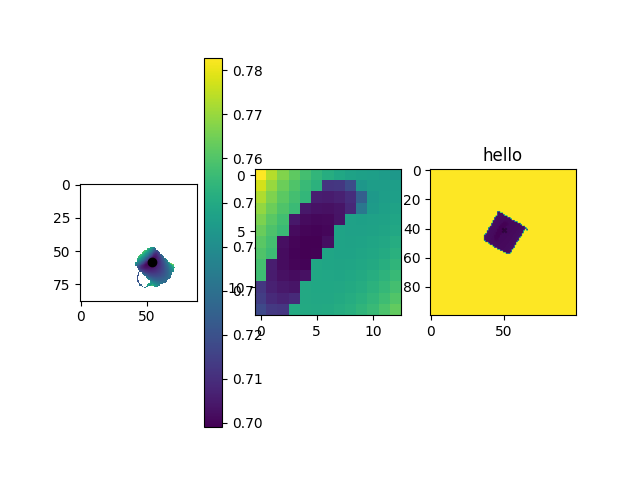

In [155]:

# observed_xyz = images_subset[5,...,:3]
i = 1
observed_xyz = test_images[i,...,:3]
heatmaps = get_errors_vmap_jit(observed_xyz, patches_centered)[:, filter_size:-filter_size,filter_size:-filter_size]
x,y = pixel_coordinates[i]
# heatmaps = heatmaps.at[heatmaps < 1e-5].set(jnp.inf)
best_idx = jnp.unravel_index(heatmaps.argmin(), heatmaps.shape)
print(best_idx)
print(heatmaps.min())
fig = plt.figure()
ax = fig.add_subplot(1, 3, 1)
d = ax.imshow(b.preprocess_for_viz( observed_xyz[filter_size:-filter_size,filter_size:-filter_size][...,2]))
fig.colorbar(d)
ax.scatter(best_idx[2], best_idx[1],color="black")


ax = fig.add_subplot(1, 3, 2)
ax.imshow(patches_centered[best_idx[0],...,2])

ax = fig.add_subplot(1, 3, 3)
ax.imshow(images_subset[best_idx[0]][...,2])
print(pixel_coordinates_subset[best_idx[0],0], pixel_coordinates_subset[best_idx[0],1])
ax.scatter(pixel_coordinates_subset[best_idx[0],0], pixel_coordinates_subset[best_idx[0],1], c='black', alpha=0.3,s=10, marker='x')
ax.set_title("hello")


(Array(297, dtype=int32), Array(58, dtype=int32), Array(54, dtype=int32))
2.1885343
50 41


Text(0.5, 1.0, 'hello')

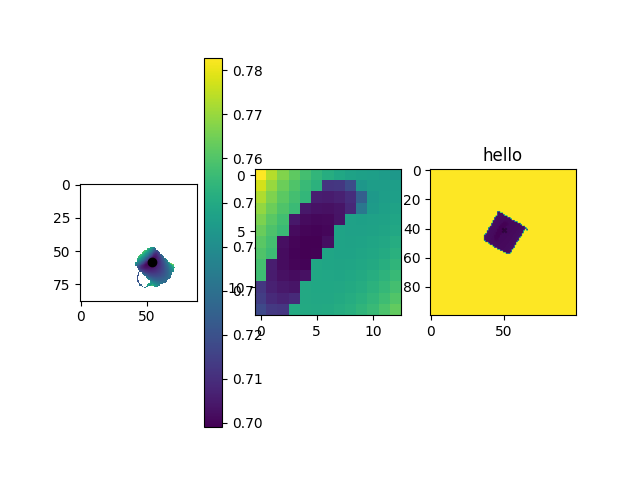

In [116]:

# observed_xyz = images_subset[5,...,:3]
observed_xyz = test_images[1,...,:3]
heatmaps = get_errors_vmap_jit(observed_xyz, patches_centered)[:, filter_size:-filter_size,filter_size:-filter_size]
# heatmaps = heatmaps.at[heatmaps < 1e-5].set(jnp.inf)
best_idx = jnp.unravel_index(heatmaps.argmin(), heatmaps.shape)
print(best_idx)
print(heatmaps.min())
fig = plt.figure()
ax = fig.add_subplot(1, 3, 1)
d = ax.imshow(b.preprocess_for_viz( observed_xyz[filter_size:-filter_size,filter_size:-filter_size][...,2]))
fig.colorbar(d)
ax.scatter(best_idx[2], best_idx[1],color="black")


ax = fig.add_subplot(1, 3, 2)
ax.imshow(patches_centered[best_idx[0],...,2])

ax = fig.add_subplot(1, 3, 3)
ax.imshow(images_subset[best_idx[0]][...,2])
print(pixel_coordinates_subset[best_idx[0],0], pixel_coordinates_subset[best_idx[0],1])
ax.scatter(pixel_coordinates_subset[best_idx[0],0], pixel_coordinates_subset[best_idx[0],1], c='black', alpha=0.3,s=10, marker='x')
ax.set_title("hello")


In [92]:
patches_centered[best_idx[0]]

Array([[[-2.20715441e-02, -2.42008269e-02,  4.73173857e-02],
        [-1.82581935e-02, -2.37965509e-02,  4.19270396e-02],
        [-1.45273944e-02, -2.34996974e-02,  3.79689932e-02],
        [-1.08516179e-02, -2.32800543e-02,  3.50404382e-02],
        [-7.20979832e-03, -2.30954550e-02,  3.25791240e-02],
        [-3.59483645e-03, -2.29445137e-02,  3.05665731e-02],
        [ 0.00000000e+00, -2.28097066e-02,  2.87691355e-02],
        [ 3.57912015e-03, -2.27087699e-02,  2.74233222e-02],
        [ 7.14905793e-03, -2.26399004e-02,  2.65050530e-02],
        [ 1.07176062e-02, -2.26099975e-02,  2.61063576e-02],
        [ 1.42843490e-02, -2.25882754e-02,  2.58167386e-02],
        [ 1.78438984e-02, -2.25536637e-02,  2.53552198e-02],
        [ 2.13834792e-02, -2.24806666e-02,  2.43819356e-02]],

       [[-2.19739750e-02, -2.02945806e-02,  4.40651178e-02],
        [-1.82016250e-02, -1.99865215e-02,  3.96642685e-02],
        [-1.44950403e-02, -1.97546110e-02,  3.63512635e-02],
        [-1.08314529e-

In [239]:
print(pixel_coordinates_subset[best_idx[0],0], pixel_coordinates_subset[best_idx[0],1])
patches[best_idx[0]][...,2]

3 20


Array([[2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.]], dtype=float32)

In [235]:
images_subset[best_idx[0],pixel_coordinates_subset[best_idx[0],0]-pixel_w, pixel_coordinates_subset[best_idx[0],1]]

Array([-0.29999998, -0.47      ,  2.        ,  0.        ], dtype=float32)

In [230]:
pixel_coordinates_subset[best_idx[0],0], pixel_coordinates_subset[best_idx[0],1]

(Array(3, dtype=int32), Array(20, dtype=int32))

206


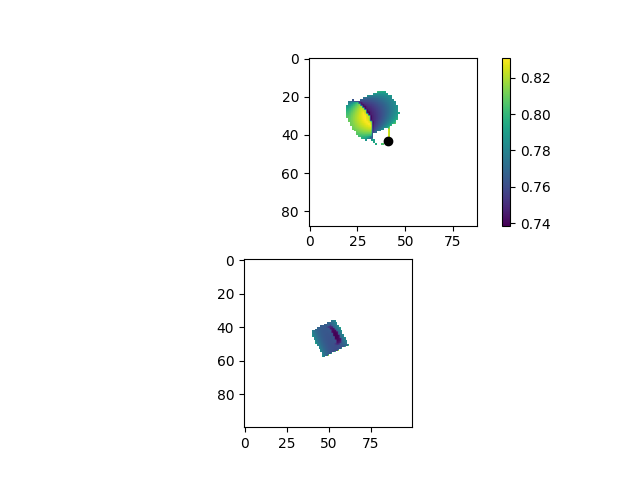

In [114]:
observed_xyz = images_subset[5,...,:3]
heatmaps = get_errors_vmap_jit(observed_xyz, patches)[:, filter_size:-filter_size,filter_size:-filter_size]
best_template_idx = jnp.unravel_index(heatmaps.argmin(), heatmaps.shape)[0]
print(best_template_idx)
heatmap = heatmaps.min(0)

fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
d = ax.imshow(b.preprocess_for_viz( observed_xyz[filter_size:-filter_size,filter_size:-filter_size][...,2]))
fig.colorbar(d)
idx = jnp.unravel_index(heatmap.argmin(), heatmap.shape)
ax.scatter(idx[1], idx[0],color="black")

ax = fig.add_subplot(2, 1, 2)
ax.imshow(b.preprocess_for_viz( images_subset[best_template_idx][...,2]))

In [175]:
test_poses = jax.vmap(b.distributions.gaussian_vmf_jit, in_axes=(0,None, None, None))(jax.random.split(jax.random.PRNGKey(10),2000), table_pose, 0.1, 1.0)
test_images = b.RENDERER.render_many(test_poses[:,None,...], jnp.array([13]))

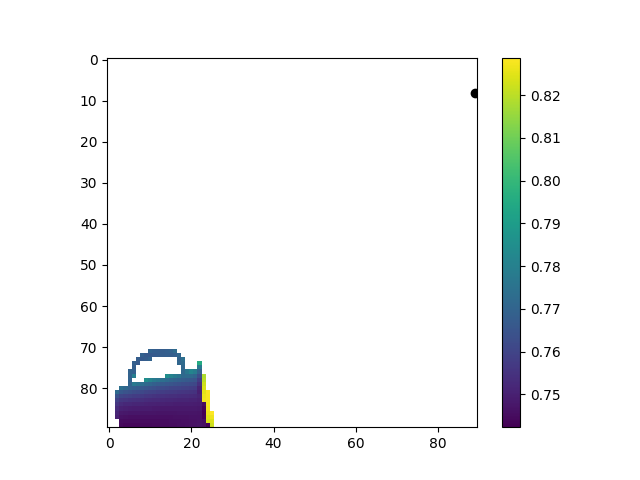

In [176]:
observed_xyz = test_images[100,...,:3]
heatmaps = get_errors_vmap_jit(observed_xyz, patches)[:, filter_size:-filter_size,filter_size:-filter_size]
heatmap = heatmaps.min(0)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
d = ax.imshow(b.preprocess_for_viz( observed_xyz[filter_size:-filter_size,filter_size:-filter_size][...,2]))
fig.colorbar(d)
idx = jnp.unravel_index(heatmap.argmin(), heatmap.shape)
ax.scatter(idx[1], idx[0],color="black")

In [28]:
patches_centered.shape

(924, 7, 7, 3)

In [16]:
patches_centered

Array([[[[-2.07818411e-02, -2.38067470e-02,  6.04981184e-02],
         [-1.64498445e-02, -2.38771290e-02,  6.16711974e-02],
         [-1.21061159e-02, -2.40304619e-02,  6.42267466e-02],
         ...,
         [ 4.78938818e-02, -9.17523950e-02,  1.19292557e+00],
         [ 5.78938834e-02, -9.17523950e-02,  1.19292557e+00],
         [ 6.78938851e-02, -9.17523950e-02,  1.19292557e+00]],

        [[-2.06233598e-02, -1.85972340e-02,  4.46499586e-02],
         [-1.63785256e-02, -1.87489055e-02,  4.74076271e-02],
         [-1.21061159e-02, -1.89057179e-02,  5.02587557e-02],
         ...,
         [ 4.78938818e-02, -8.17523897e-02,  1.19292557e+00],
         [ 5.78938834e-02, -8.17523897e-02,  1.19292557e+00],
         [ 6.78938851e-02, -8.17523897e-02,  1.19292557e+00]],

        [[-2.05427147e-02, -1.39353871e-02,  3.65855098e-02],
         [-1.63396634e-02, -1.40878670e-02,  3.96350622e-02],
         [-1.21061159e-02, -1.42397322e-02,  4.26723957e-02],
         ...,
         [ 4.78938818e-0

In [18]:
b.show_cloud("1", patches_centered[0].reshape(-1,3))

In [65]:
b.show_cloud("1", patches_centered[20].reshape(-1,3))

In [47]:
pixel_coordinates_subset.shape

(884, 2)

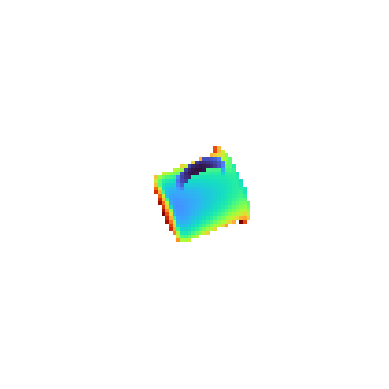

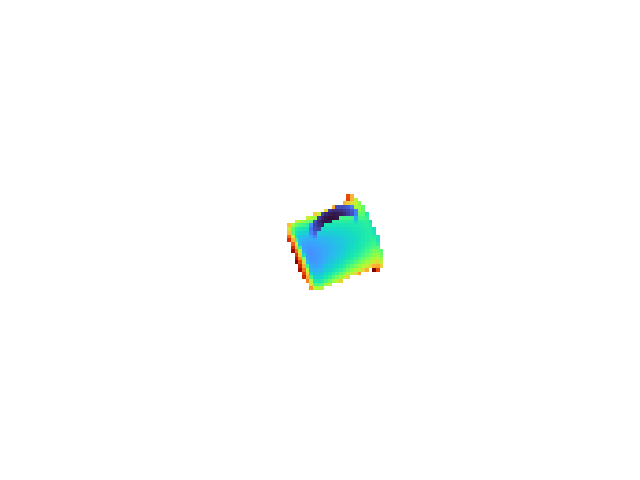

In [42]:
b.viz_depth_image(img[i,...,2])

In [ ]:
b.show_cloud("!")

In [ ]:
K = 4
def predict_based_on_patch(patch, convolutional_kernel):
    """
        patch: (K,K,3) point cloud patch
    """
    centered_patch = patch - patch[K,K,:]


In [77]:
img[jnp.arange(img.shape[0]), pixel_coordinates[:,1], pixel_coordinates[:,0], :3] - coordinates

TypeError: sub got incompatible shapes for broadcasting: (100, 3), (100, 4).

In [54]:
coordinates = jnp.einsum("j,kij->ki", b.add_homogenous_ones(coordinate_in_object_frame), random_poses)
pixel_coordinates = b.camera.project_cloud_to_pixels(coordinates, intrinsics).astype(jnp.int32)


In [ ]:
images =

In [44]:
pixel_coordinates = b.camera.project_cloud_to_pixels(b.apply_transform(coordinate_in_object_frame.reshape(-1,3), random_pose), intrinsics).astype(jnp.int32)


ValueError: Einstein sum subscript 'ij' does not contain the correct number of indices for operand 0.